In [10]:
import os
import glob
import lsst.eotest.image_utils as imutils
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as raft
import matplotlib.pyplot as plt
import numpy as np
import yaml
import sys
sys.path.insert(0, '../')
import ccob_utils as u
import ccob_beam as beam
import scipy
%load_ext autoreload
%autoreload 2

from astropy.io import fits

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
lambda_arr = ['nm960','nm850','nm750','red','blue', 'uv']
#f='/gpfs/slac/lsst/fs3/g/data/rawData/focal-plane/20220105/MC_C_20220105_000031/MC_C_20220105_000031_R22_S11.fits'
gf='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/13144/ptc_BOT/v0/106924/R22_S11_13144_eotest_results.fits'
gains = u.gains(gf, is_PTC=False)
gains_ptc = u.gains(gf, is_PTC=True)

In [35]:
for l in lambda_arr:
    locdir = f'/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/13259/BOT_acq/v0/107762/ccob_{l}_0.0_0.0_*'
    flist = glob.glob(os.path.join(locdir,"*R22_S11*"))
#     print(os.path.join(locdir,"*R22_S11*"))
#     print(l, flist)
    f = flist[0]
    hdu = fits.open(f)
    print(l, hdu[0].header['CCOBADC'])

nm960 0.510883
nm850 0.313817
nm750 0.319005
red 0.33188
blue 0.386131
uv 0.461257


In [37]:
l = 'red'
locdir = f'/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/13259/BOT_acq/v0/107762/ccob_{l}_0.0_0.0_*'
flist = glob.glob(os.path.join(locdir,"*R22_S11*"))
#     print(os.path.join(locdir,"*R22_S11*"))
#     print(l, flist)
f = flist[0]
hdu = fits.open(f)
print(l, hdu[0].header['CCOBADC'])

red 0.33188


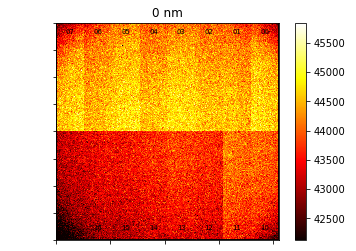

In [38]:
sensorTest.plot_flat(f)

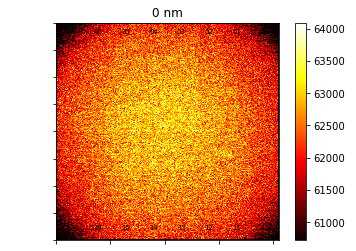

In [39]:
sensorTest.plot_flat(f, gains=gains_ptc)

In [11]:
mosaic, amp_coord = u.make_ccd_2d_array(f, gains=None, biasfile=None)
mosaic2, amp_coord2 = u.make_ccd_2d_array(f, gains=gains_ptc, biasfile=None)
m_sm = scipy.ndimage.filters.gaussian_filter(mosaic, 10, mode='constant')
m2_sm = scipy.ndimage.filters.gaussian_filter(mosaic2, 10, mode='constant')

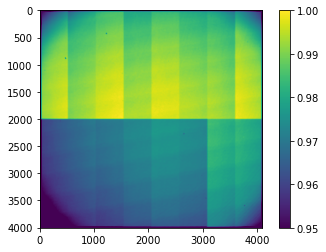

In [49]:
plt.imshow(m_sm/np.max(m_sm.flatten()), vmin=0.95)
#plt.imshow(mosaic, vmin=35000)
plt.colorbar()

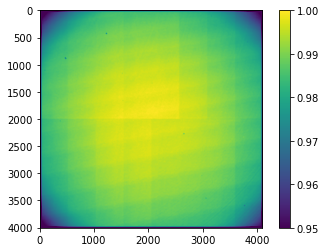

In [50]:
plt.imshow(m2_sm/np.max(m2_sm.flatten()), vmin=0.95)
#plt.imshow(mosaic2, vmin=50000, vmax=59000)
plt.colorbar()

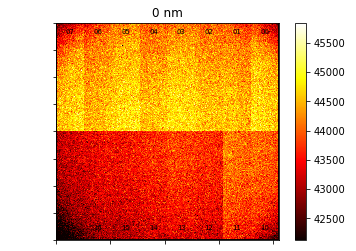

In [17]:
sensorTest.plot_flat(f)

# 12 x 12 beam reconstruction

In [3]:
configfile = "../beam_config.yaml"
config = u.load_ccob_config(configfile)
dirlist = []
for d in config['rundir']:
    dirlist += glob.glob(config['rootdir']+d+'ccob_'+config['led_name']+'*')

assert (len(dirlist)/config['scan_size']).is_integer, f'{len(dirlsit)} = Wrong number of scan locations'

print(f'Scan over {len(dirlist)} locations')

b = beam.CcobBeam(config)
for i in np.arange(config['scan_size']): 
    # that's just to allow saving the data at every line of the scan in case
    # the job is interrupted.
    print(f'Loading row {i}')
    start = i*config['scan_size']
    end = (i+1)*config['scan_size']
    b.read_multibunch(config, dirlist=dirlist[start:end], silent=True)
    b.save(os.path.join(config['tmpdir'],
                        'beam_object_'+config['ref_raft']+'_'+config['ref_slot']+'_'+config['led_name']+'.pkl'))   

# b.interp_beam_BOT(amp=config['ref_amp'], pd_corr=True)
# im = b.make_image_BOT()
# b.find_max_from_avg()
# b.save(os.path.join(config['tmpdir'],
#                     'beam_object_'+config['ref_raft']+'_'+config['ref_slot']+'_'+config['led_name']+'.pkl')) 

Scan over 144 locations
Loading row 0
Loading row 1
Loading row 2
Loading row 3
Loading row 4
Loading row 5
Loading row 6
Loading row 7
Loading row 8
Loading row 9
Loading row 10
Loading row 11


In [16]:
configfile = "../beam_config.yaml"
config = u.load_ccob_config(configfile)
config

{'led_name': 'nm850',
 'rootdir': '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/',
 'rundir': ['/13260/BOT_acq/v0/107781/'],
 'scan_size': 12,
 'tmpdir': '/home/combet/tmp_Run5',
 'ref_raft': 'R22',
 'ref_slot': 'S11',
 'ref_amps': [5],
 'ref_pix_x': 1000,
 'ref_pix_y': 256,
 'npix_for_avg': 30,
 'path': './',
 'current': '*',
 'exp_time': '*',
 'xpos': '*',
 'ypos': '*',
 'slot': '*'}

In [17]:
import pickle as pkl
from ccob_beam import CcobBeam
bb = pkl.load(open('/home/combet/tmp_Run5/beam_object_R22_S11_red.pkl','rb'))
bb.config == config

False

In [12]:
b.interp_beam_BOT(amp=5, pd_corr=False)

In [13]:
im = b.make_image_BOT()

In [14]:
b.find_max_from_avg()

In [15]:
b.save(os.path.join(config['tmpdir'],'beam_object_'+config['ref_raft']+'_'+config['ref_slot']+'_'+config['led_name']+'.pkl')) 

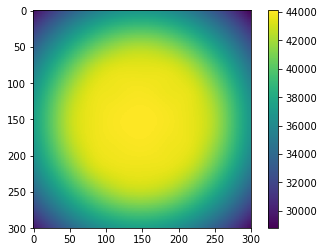

In [16]:
plt.imshow(im)
plt.colorbar()

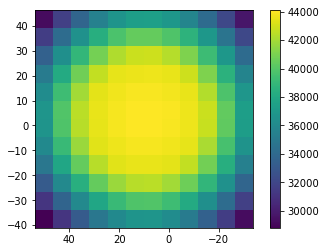

In [17]:
amp=5 # 1-16, select the channel used for the reconstruction. 5 = Segment14

binsize = (max(b.raw_data['yarr'])-min(b.raw_data['yarr']))/(config['scan_size']-1)
extent = [max(b.raw_data['xarr'])+binsize/2,
          min(b.raw_data['xarr'])-binsize/2,
          min(b.raw_data['yarr'])-binsize/2, 
          max(b.raw_data['yarr'])+binsize/2]

#tmp1 = np.asarray(b.raw_data['val'][amp])/np.asarray(b.raw_data['pd_value']) # correct for the control photodiode value
tmp1 = np.asarray(b.raw_data['val'][amp]) # correct for the control photodiode value
tmp2 = tmp1 / max(tmp1) # normalise to the max

plt.imshow(np.flip(np.reshape(tmp1,(config['scan_size'],config['scan_size'])).T,axis=1), extent=extent, origin='lower')
plt.colorbar()
#plt.title(ref_raft+', '+ref_slot+', Amp #'+str(amp)+', led = '+led+', baffle='+baffle)


In [38]:
b.raw_data['val'][amp]

[29281.547,
 31672.705,
 33757.234,
 35448.582,
 36647.594,
 37292.258,
 37346.348,
 36806.027,
 35721.668,
 34120.81,
 32093.432,
 29747.514,
 31593.373,
 34207.33,
 36506.527,
 38361.6,
 39669.85,
 40361.875,
 40419.504,
 39830.215,
 38652.277,
 36903.766,
 34672.938,
 32099.168,
 33569.92,
 36412.36,
 38884.574,
 40849.574,
 42156.883,
 42801.266,
 42857.734,
 42325.2,
 41126.46,
 39290.48,
 36916.664,
 34149.355,
 35150.125,
 38152.05,
 40747.266,
 42667.207,
 43508.76,
 43687.26,
 43704.11,
 43581.266,
 42925.516,
 41149.664,
 38692.0,
 35767.02,
 36240.625,
 39337.324,
 41944.746,
 43463.73,
 43769.223,
 43943.152,
 43976.02,
 43836.543,
 43570.46,
 42372.57,
 39899.98,
 36881.676,
 36767.203,
 39918.508,
 42513.797,
 43592.38,
 43903.734,
 44064.69,
 44095.066,
 43955.215,
 43692.805,
 42915.31,
 40507.348,
 37435.555,
 36700.223,
 39869.883,
 42456.133,
 43575.895,
 43858.16,
 44047.61,
 44069.22,
 43930.383,
 43673.477,
 42863.207,
 40450.89,
 37371.332,
 36066.45,
 39156.73,


In [18]:
b.properties

{'ref_raft': 'R22',
 'ref_slot': 'S11',
 'ref_amp': [4, 5, 15],
 'ref_pix_x': 1000,
 'ref_pix_y': 256,
 'npix_for_avg': 30,
 'analysis_amp': 5,
 'ncols': 300,
 'nrows': 300,
 'max_xccob': 9.078545150501668,
 'max_yccob': 3.501454849498323,
 'max_xarg': 146,
 'max_yarg': 153}

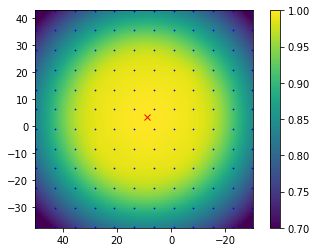

In [19]:
b.plot_BOT()

# Scan images

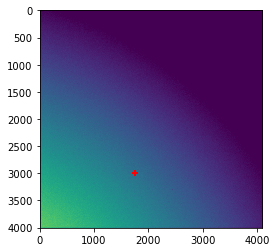

In [77]:
import re
# sort list according to last number
dirlist2 = sorted(dirlist, key=lambda x: int(re.search(r'\d+$',x).group())) 

gf='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/13144/ptc_BOT/v0/106924/R22_S11_13144_eotest_results.fits'
gains = u.gains(gf, is_PTC=True)
for i,d in enumerate (dirlist2):
    f = glob.glob(os.path.join(d, '*R22_S11*'))[0]
    mosaic, amp_coord = u.make_ccd_2d_array(f, gains=gains, biasfile=None)
#    m_sm = scipy.ndimage.filters.gaussian_filter(mosaic, 10, mode='constant')
    plt.imshow(mosaic, vmin=30000, vmax=63000)
    plt.scatter([1750],[3000], marker='+', color='red')
    plt.savefig(f'/home/combet/tmp/scan_{i}.png')

# Compare beam models for the various wavelength

In [29]:
ddir = '/home/combet/tmp_Run5'
led_arr = ['uv', 'blue', 'red','nm750','nm850','nm960']

b={}
for i,l in enumerate(led_arr):
    b[l]=pkl.load(open(os.path.join(ddir,f'beam_object_R22_S11_{l}.pkl'),'rb'))


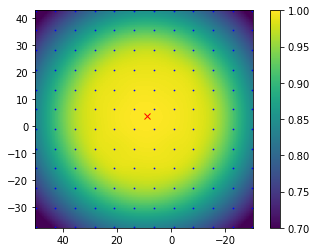

In [31]:
b['red'].plot_BOT()

In [48]:
blue = b['blue'].beam_image['beam']/np.max(b['blue'].beam_image['beam'].flatten())
red = b['red'].beam_image['beam']/np.max(b['red'].beam_image['beam'].flatten())
uv = b['uv'].beam_image['beam']/np.max(b['uv'].beam_image['beam'].flatten())
nm750 = b['nm750'].beam_image['beam']/np.max(b['nm750'].beam_image['beam'].flatten())
nm850 = b['nm850'].beam_image['beam']/np.max(b['nm850'].beam_image['beam'].flatten())
nm960 = b['nm960'].beam_image['beam']/np.max(b['nm960'].beam_image['beam'].flatten())

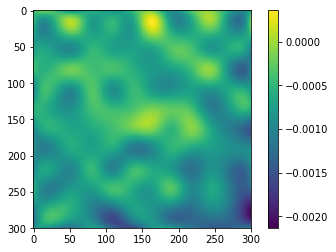

In [57]:
plt.imshow(red/blue-1.)
plt.colorbar()

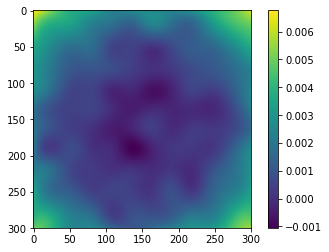

In [56]:
plt.imshow(red/uv-1.)
plt.colorbar()

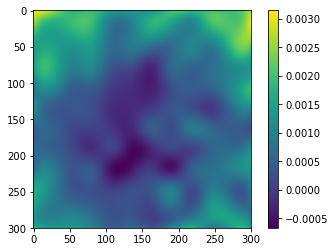

In [54]:
plt.imshow(red/nm750-1.)
plt.colorbar()

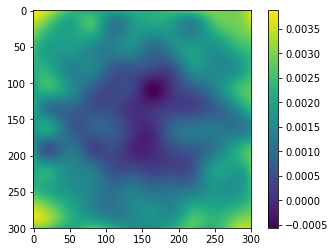

In [53]:
plt.imshow(red/nm850-1.)
plt.colorbar()

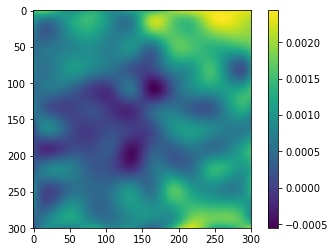

In [58]:
plt.imshow(red/nm960-1.)
plt.colorbar()